<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/ImageNET_VGG_Unet_batch_normalized_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
colorization_path = '/content/drive/MyDrive/colorization'
!tar -zxvf /content/drive/MyDrive/colorization/val.tar.gz


Streaming output truncated to the last 5000 lines.
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00026555.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00000278.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00037766.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00025525.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00017595.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00028051.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00043844.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00034269.JPEG
kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00002796.JPEG
kagg

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [ ]:

def stack_lab(l, ab):
  return torch.cat((l, ab))

def lab2rgb(lab, to_numpy):
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy().permute(2,0,1)

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. Load Data

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_filenames = os.listdir(self.folder_path)
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.folder_path, self.image_filenames[index])
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))
        
        
        return L, ab


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256,256))
])

dataset = ColorizationDataset('/content/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val', transform)

train_size = int(.8* len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# II. Preparing the Model

In [ ]:
import torchvision.models as models

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )


class VGGUnet(nn.Module):

    def __init__(self, out_channels=2):
        super().__init__()

        self.encoder = models.vgg16_bn(weights='DEFAULT').features
        for param in self.encoder.parameters():
          param.requires_grad = False
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = double_conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = double_conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = double_conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = double_conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = double_conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = double_conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        x = x.expand(-1, 3, -1, -1)

        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x


# III. Training 

In [ ]:
# Training loop
def train_loop(model, trainloader, criterion, optimizer, progress_bar):
    model.train()
    running_loss = 0.0

    for grayscale_images, colored_images in progress_bar:
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss = criterion(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(trainloader)

    return average_loss

# Evaluation loop
def evaluate_loop(model, testloader, criterion, progressbar):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colored_images in progressbar:
            grayscale_images = grayscale_images.to(device)
            colored_images = colored_images.to(device)

            # Forward pass
            predicted_images = model(grayscale_images)

            # Compute the loss
            loss = criterion(predicted_images, colored_images)

            # Accumulate loss
            running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(testloader)

    return average_loss


def train_evaluate(num_epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    validation_losses = [] 
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end='  ')
        pbar = tqdm(train_loader, leave=False)
        pbar.set_description(f'Train {epoch+1}/{num_epochs}')
        train_loss = train_loop(model, train_loader, criterion, optimizer, pbar)
        print(f"Train Loss: {train_loss}", end='  ')

        evalbar = tqdm(val_loader, leave=False)
        evalbar.set_description(f'Val {epoch+1}/{num_epochs}')
        val_loss = evaluate_loop(model, val_loader, criterion, evalbar)
        print(f"Validation Loss: {val_loss}")
        train_losses.append(train_loss)
        validation_losses.append(val_loss)
    return train_losses, validation_losses

def train(num_epochs, model, train_loader, criterion, optimizer):
    train_losses = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end='  ')
        pbar = tqdm(train_loader, leave=False)
        pbar.set_description(f'Train {epoch+1}/{num_epochs}')
        train_loss = train_loop(model, train_loader, criterion, optimizer, pbar)
        print(f"Train Loss: {train_loss}")
        train_losses.append(train_loss)
    return train_losses

def plot_loss(losses, path=None):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    if path :
        plt.savefig(path)


In [ ]:

# Training and evaluation loop (to execute multiple times)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Set up training parameters
lr = 0.001

# Initialize your U-Net model
model = VGGUnet()
model.to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:10<00:00, 51.1MB/s]


In [ ]:
colorization_path = '/content/drive/MyDrive/colorization'

num_epochs = 50
plot_path = f'{colorization_path}/plots/loss_plot.png'

losses = train(num_epochs, model, train_loader, criterion, optimizer)

torch.save(model.state_dict(), '/content/drive/MyDrive/colorization/models/imagenet_vgg_bn_unet_lab.pth')

plot_loss(losses, plot_path)

Epoch 1/50:  

Train Loss: 9.493214386558533
Epoch 2/50:  

Train Loss: 9.263992718887328
Epoch 3/50:  

Train Loss: 9.156480112266541
Epoch 4/50:  

Train Loss: 9.037102037239075
Epoch 5/50:  

Train Loss: 8.943792594528198
Epoch 6/50:  

Train Loss: 8.849639827728272
Epoch 7/50:  

Train 7/50:  45%|████▌     | 1126/2500 [08:20<09:21,  2.45it/s]

# IV. Test the model

on training data

torch.Size([2, 256, 256])
24


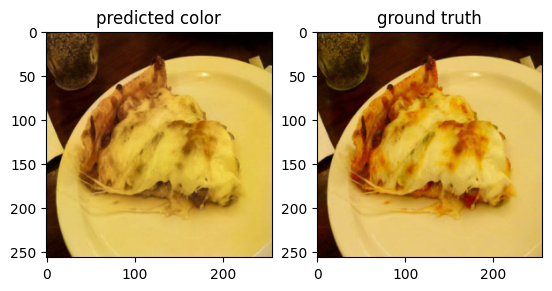

In [ ]:
import random 
model = VGGUnet()
model.load_state_dict(torch.load('/content/drive/MyDrive/colorization/models/imagenet_vgg_bn_unet_lab.pth', map_location=device))
model.eval()

index = random.randint(0,len(val_dataset))
input, label = val_dataset[index]
rgb_label = to_rgb(input, label)

output = model(input.unsqueeze(0)).squeeze()
print(output.shape)
rgb_pred = to_rgb(input.cpu(), output.cpu())

input.shape, label.shape, output.shape
rgb_pred.shape, rgb_label.shape
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2)  


axes[0].imshow(rgb_pred)
axes[0].set_title('predicted color')

axes[1].imshow(rgb_label)
axes[1].set_title('ground truth')
print(index)
